In [1]:
# do all the import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from scipy import signal
import numpy as np
import math

In [2]:
def normalize(A, maxA):
    time = A[maxA,1]
    S = np.zeros_like(A)
    S[:,1] = time
    A -= S
    return A[maxA:,]

def get_python(filename):
    d = np.genfromtxt(filename, delimiter=',')
    ms = d[:,0]
    mem_in_kiby = d[:,1]
    max_v = np.max(ms)
    for i in range(10, ms.shape[0]):
        if ms[i] == 0:
            ms[i] = max_v
    
    ms *= 1.5
    return ms/1000, mem_in_kiby/1024

def extract_massif(filename):
    f = open(filename, 'r')
    values = []
    c = -1
    c_time = -1
    c_heap = -1
    max_pos = -1
    max_value = -1
    c_extra = -1
    for line in f:
        if line.startswith("snapshot="):
            c = int(line.replace('snapshot=', ''))
        elif line.startswith("time="):
            c_time = int(line.replace('time=', ''))
        elif line.startswith("mem_heap_B="):
            c_heap = int(line.replace('mem_heap_B=', ''))/1024
        elif line.startswith('mem_heap_extra_B='):
            c_extra = int(line.replace('mem_heap_extra_B=', ''))
            values.append([c, c_time, c_heap, c_extra])
            if (c_heap + c_extra) > max_value:
                max_value = c_heap + c_extra
                max_pos = c
    return normalize(np.array(values), max_pos)

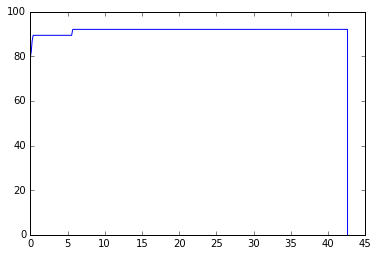

In [3]:
ms, kb = get_python('python_memusage.txt')

plt.plot(ms, kb)
plt.show()

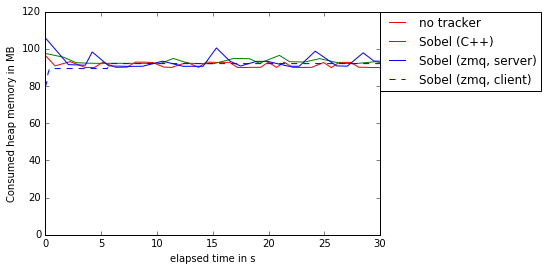

In [4]:
def ugly_add(A, B, xA, xB):
    Bigger = A.copy()
    Smaller = B.copy()
    X = xB.copy()
    if B.shape[0] > A.shape[0]:
        Bigger = B.copy()
        Smaller = A.copy()
        X = xA.copy()
    R = np.zeros(Smaller.shape[0])
    R = Smaller
    for i in range(0, Smaller.shape[0]):
        R[i] += Bigger[i]
    return R, X

V = extract_massif('massif.out.racecar_sobel')

x = V[:,1]/1000
y1 = V[:,2]/1024

Vpy = extract_massif('massif.out.racecar_sobel_py')
x_py = Vpy[:,1]/1000
y1_py = Vpy[:,2]/1024

Vc = extract_massif('massif.out.racecar_sobel_cpp')
x_c = Vc[:,1]/1000
y1_c = Vc[:,2]/1024

#fig = plt.figure(figsize=(16, 8))
f, ax = plt.subplots(1,1, figsize=(6, 4), sharex=True, sharey=False)
norm = ax.plot(x,y1, 'r', label="no tracker")
cpp = ax.plot(x_c,y1_c, 'g', label='Sobel (C++)')
pyth = ax.plot(x_py,y1_py, 'b', label="Sobel (zmq, server)")

zmq_s = ax.plot(ms, kb, 'b--', label="Sobel (zmq, client)")

# add together..
Co, CoX = ugly_add(y1_py, kb, x_py, ms)
#comb = ax.plot(CoX, Co, 'r', label="Sobel (zmq)")

#ax.set_yscale('log')

plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)
plt.xlim(0, 30)
plt.ylabel('Consumed heap memory in MB')
plt.xlabel('elapsed time in s')
#plt.ylim(80000, 200000)
plt.show()
#plt.savefig('zmq_mem')

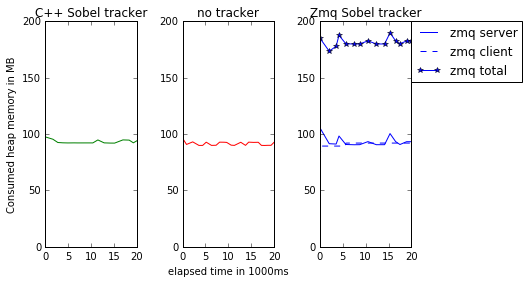

In [5]:
RIGHT = 20

fig = plt.figure()




a3 = plt.subplot(133)
a3.set_title('Zmq Sobel tracker')
la = a3.plot(x_py,y1_py, 'b', label="zmq server")
lb = a3.plot(ms, kb, 'b--', label="zmq client")
lc = a3.plot(CoX, Co, 'b-*', label="zmq total")

a3.set_xlim([0, RIGHT])
lgd = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)


#plt.ylabel('Consumed heap memory in MB')

a1 = plt.subplot(132, sharex=a3, sharey=a3)
a1.plot(x,y1, 'r', label="no tracker")
a1.set_xlim([0, RIGHT])

a1.set_title('no tracker')

plt.xlabel('elapsed time in 1000ms')
a2 = plt.subplot(131, sharex=a3, sharey=a3)
a2.plot(x_c,y1_c, 'g', label='Sobel (C++)')
a2.set_xlim([0, RIGHT])
a2.set_title('C++ Sobel tracker')
a2.set_ylabel('Consumed heap memory in MB')



#plt.show()
#plt.show()
plt.tight_layout()
plt.savefig('mem.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

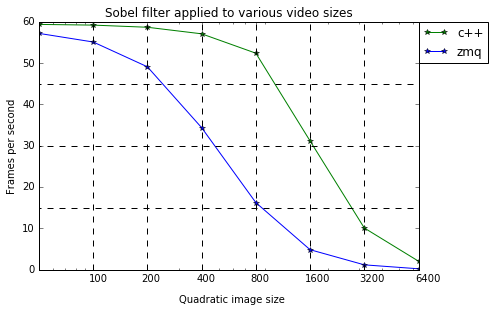

In [93]:
# TIMING
def get_avg(file):
    li = np.genfromtxt(file)
    return np.average(li)

cpp_ = []
cpp_.append([50, get_avg("speed/50_cpp.txt"), get_avg("speed/50_py.txt")])
cpp_.append([100, get_avg("speed/100_cpp.txt"), get_avg("speed/100_py.txt")])
cpp_.append([200, get_avg("speed/200_cpp.txt"), get_avg("speed/200_py.txt")])
cpp_.append([400, get_avg("speed/400_cpp.txt"), get_avg("speed/400_py.txt")])
cpp_.append([800, get_avg("speed/800_cpp.txt"), get_avg("speed/800_py.txt")])
cpp_.append([1600, get_avg("speed/1600_cpp.txt"), get_avg("speed/1600_py.txt")])
cpp_.append([3200, get_avg("speed/3200_cpp.txt"), get_avg("speed/3200_py.txt")])
cpp_.append([6400, get_avg("speed/6400_cpp.txt"), get_avg("speed/6400_py.txt")])
A = np.array(cpp_)

x = A[:,0]
cpp = A[:,1]
py = A[:,2]


plot = plt.subplot(111)
cpp_line = plot.plot(x,cpp, 'g-*', label='c++')
py_line = plot.plot(x,py, 'b-*', label='zmq')

plot.plot([50,50], [0, 60], 'k--')
plot.plot([100,100], [0, 60], 'k--')
plot.plot([200,200], [0, 60], 'k--')
plot.plot([400,400], [0, 60], 'k--')
plot.plot([800,800], [0, 60], 'k--')
plot.plot([1600,1600], [0, 60], 'k--')
plot.plot([3200,3200], [0, 60], 'k--')
plot.plot([6400,6400], [0, 60], 'k--')
plot.plot([0,6400], [15, 15], 'k--')
plot.plot([0,6400], [30, 30], 'k--')
plot.plot([0,6400], [45, 45], 'k--')

plot.text(95, -3, '100')
plot.text(185, -3, '200')
plot.text(375, -3, '400')
plot.text(750, -3, '800')
plot.text(1500, -3, '1600')
plot.text(3000, -3, '3200')
plot.text(6100, -3, '6400')

#plot.plot([x[0], x[-1]], [cpp[0], cpp[-1]])

plot.set_xscale('log')
plot.set_xlim([50, 6400])

plot.get_xaxis().set_ticks([])

plot.set_ylabel('Frames per second')
plot.text(300, -8, 'Quadratic image size')
#plot.set_xlabel('Consumed heap memory in MB')

plt.title("Sobel filter applied to various video sizes")
lgd = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()
#plt.savefig('fps.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

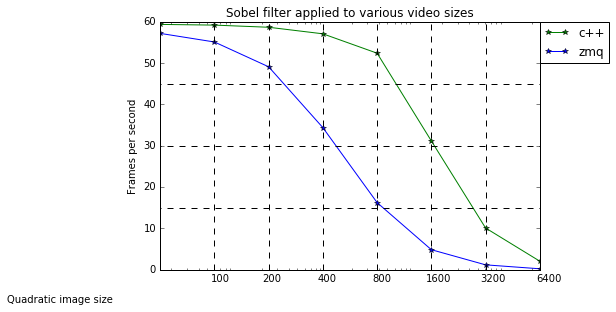

In [95]:
# TIMING
def get_avg(file):
    li = np.genfromtxt(file)
    return np.average(li)

cpp_ = []
cpp_.append([50, get_avg("speed/50_cpp.txt"), get_avg("speed/50_py.txt")])
cpp_.append([100, get_avg("speed/100_cpp.txt"), get_avg("speed/100_py.txt")])
cpp_.append([200, get_avg("speed/200_cpp.txt"), get_avg("speed/200_py.txt")])
cpp_.append([400, get_avg("speed/400_cpp.txt"), get_avg("speed/400_py.txt")])
cpp_.append([800, get_avg("speed/800_cpp.txt"), get_avg("speed/800_py.txt")])
cpp_.append([1600, get_avg("speed/1600_cpp.txt"), get_avg("speed/1600_py.txt")])
cpp_.append([3200, get_avg("speed/3200_cpp.txt"), get_avg("speed/3200_py.txt")])
cpp_.append([6400, get_avg("speed/6400_cpp.txt"), get_avg("speed/6400_py.txt")])
A = np.array(cpp_)

x = A[:,0]
cpp = A[:,1]
py = A[:,2]

def f(e):
    return e*e*3*2

x = f(x)

plot = plt.subplot(111)
cpp_line = plot.plot(x,cpp, 'g-*', label='c++')
py_line = plot.plot(x,py, 'b-*', label='zmq')

plot.plot([f(50),f(50)], [0, 60], 'k--')
plot.plot([f(100),f(100)], [0, 60], 'k--')
plot.plot([f(200),f(200)], [0, 60], 'k--')
plot.plot([f(400),f(400)], [0, 60], 'k--')
plot.plot([f(800),f(800)], [0, 60], 'k--')
plot.plot([f(1600),f(1600)], [0, 60], 'k--')
plot.plot([f(3200),f(3200)], [0, 60], 'k--')
plot.plot([f(6400),f(6400)], [0, 60], 'k--')
plot.plot([0,f(6400)], [15, 15], 'k--')
plot.plot([0,f(6400)], [30, 30], 'k--')
plot.plot([0,f(6400)], [45, 45], 'k--')

plot.text(f(95), -3, '100')
plot.text(f(185), -3, '200')
plot.text(f(375), -3, '400')
plot.text(f(750), -3, '800')
plot.text(f(1500), -3, '1600')
plot.text(f(3000), -3, '3200')
plot.text(f(6100), -3, '6400')

#plot.plot([x[0], x[-1]], [cpp[0], cpp[-1]])

plot.set_xscale('log')
plot.set_xlim([f(50), f(6400)])

plot.get_xaxis().set_ticks([])

plot.set_ylabel('Frames per second')
plot.text(300, -8, 'Quadratic image size')
#plot.set_xlabel('Consumed heap memory in MB')

plt.title("Sobel filter applied to various video sizes")
lgd = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()
#plt.savefig('fps.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

[(15000, 5), (60000, 5), (240000, 5), (960000, 5), (3840000, 5), (15360000, 4), (61440000, 3), (245760000, 1)]


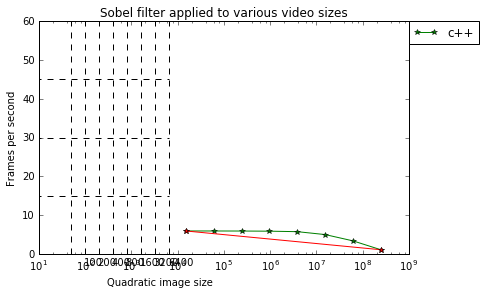

In [79]:
# TIMING
def get_avg(file):
    li = np.genfromtxt(file)
    return np.average(li)

cpp_ = []
cpp_.append([50, get_avg("speed/50_cpp.txt"), get_avg("speed/50_py.txt")])
cpp_.append([100, get_avg("speed/100_cpp.txt"), get_avg("speed/100_py.txt")])
cpp_.append([200, get_avg("speed/200_cpp.txt"), get_avg("speed/200_py.txt")])
cpp_.append([400, get_avg("speed/400_cpp.txt"), get_avg("speed/400_py.txt")])
cpp_.append([800, get_avg("speed/800_cpp.txt"), get_avg("speed/800_py.txt")])
cpp_.append([1600, get_avg("speed/1600_cpp.txt"), get_avg("speed/1600_py.txt")])
cpp_.append([3200, get_avg("speed/3200_cpp.txt"), get_avg("speed/3200_py.txt")])
cpp_.append([6400, get_avg("speed/6400_cpp.txt"), get_avg("speed/6400_py.txt")])
A = np.array(cpp_)

x = A[:,0]
cpp = A[:,1]
py = A[:,2]

x = x*x*3*2
cpp = np.log(cpp)/np.log(2)
#cpp = np.log(x)/np.log(2)

#x = x*x*2*3
#x = np.log(x)/np.log(2)

OUT = []
for i in range(0, x.shape[0]):
    OUT.append((int(x[i]), int(cpp[i])))
print(OUT)

plot = plt.subplot(111)
cpp_line = plot.plot(x,cpp, 'g-*', label='c++')
#py_line = plot.plot(x,py, 'b-*', label='zmq')

x_ideal = np.array([x[0], x[-1]])
y_ideal = np.array([cpp[0], cpp[-1]])
plot.plot(x_ideal, y_ideal, 'r-*')

#x_ideal = np.array([x[0], x[-1]])
#y_ideal = np.array([cpp[0], cpp[-1]])
#plot.plot(x_ideal, y_ideal, 'r*')

plot.plot([50,50], [0, 60], 'k--')
plot.plot([100,100], [0, 60], 'k--')
plot.plot([200,200], [0, 60], 'k--')
plot.plot([400,400], [0, 60], 'k--')
plot.plot([800,800], [0, 60], 'k--')
plot.plot([1600,1600], [0, 60], 'k--')
plot.plot([3200,3200], [0, 60], 'k--')
plot.plot([6400,6400], [0, 60], 'k--')
plot.plot([0,6400], [15, 15], 'k--')
plot.plot([0,6400], [30, 30], 'k--')
plot.plot([0,6400], [45, 45], 'k--')

plot.text(95, -3, '100')
plot.text(185, -3, '200')
plot.text(375, -3, '400')
plot.text(750, -3, '800')
plot.text(1500, -3, '1600')
plot.text(3000, -3, '3200')
plot.text(6100, -3, '6400')

plot.set_xscale('log')
#plot.set_xlim([50, 6400])

#plot.get_xaxis().set_ticks([])

plot.set_ylabel('Frames per second')
plot.text(300, -8, 'Quadratic image size')
#plot.set_xlabel('Consumed heap memory in MB')

plt.title("Sobel filter applied to various video sizes")
lgd = plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()
#plt.savefig('fps.eps', format='eps', bbox_extra_artists=(lgd,), bbox_inches='tight')